# **VAEs**



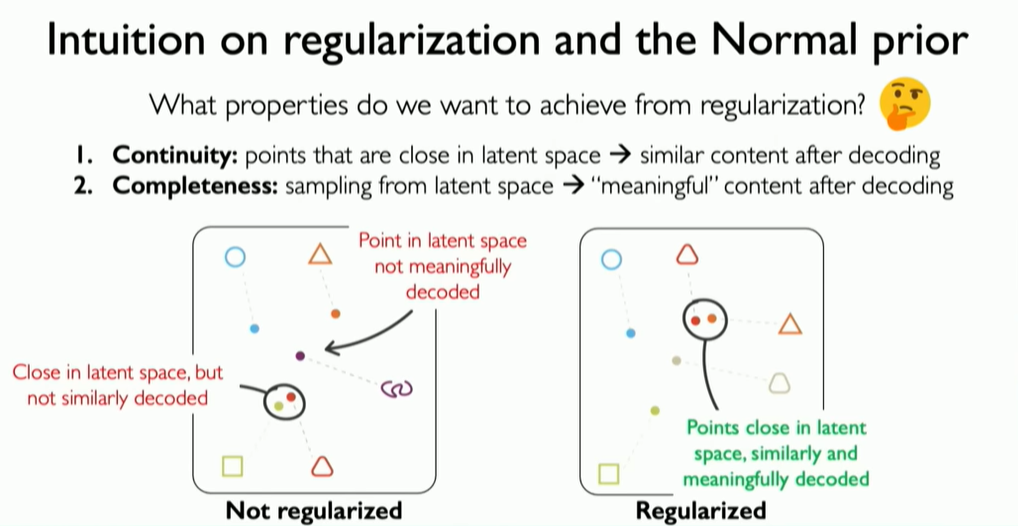

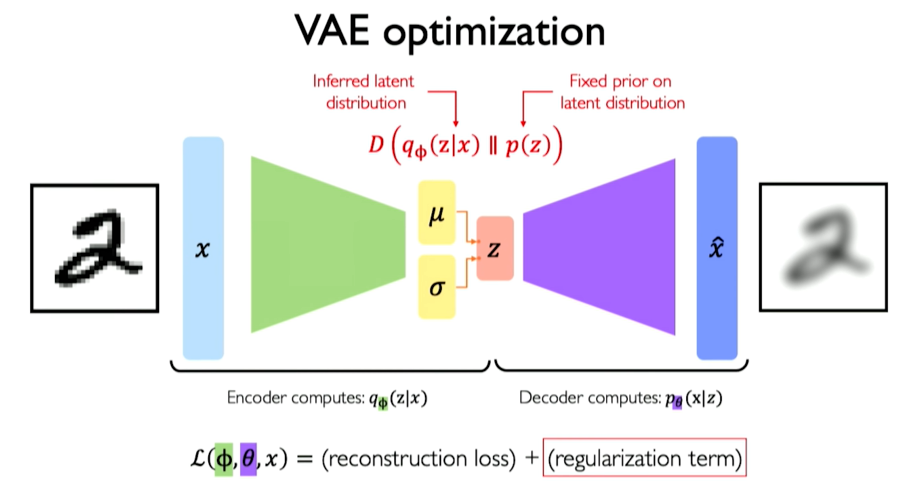

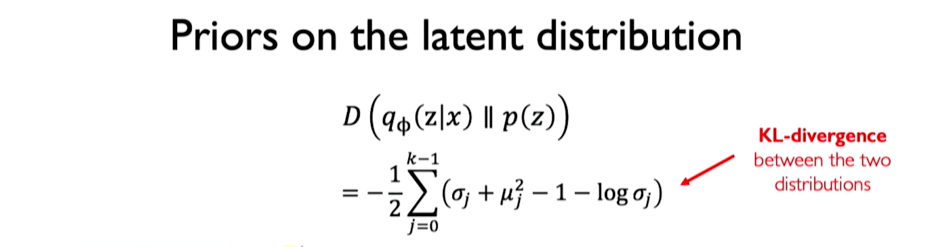

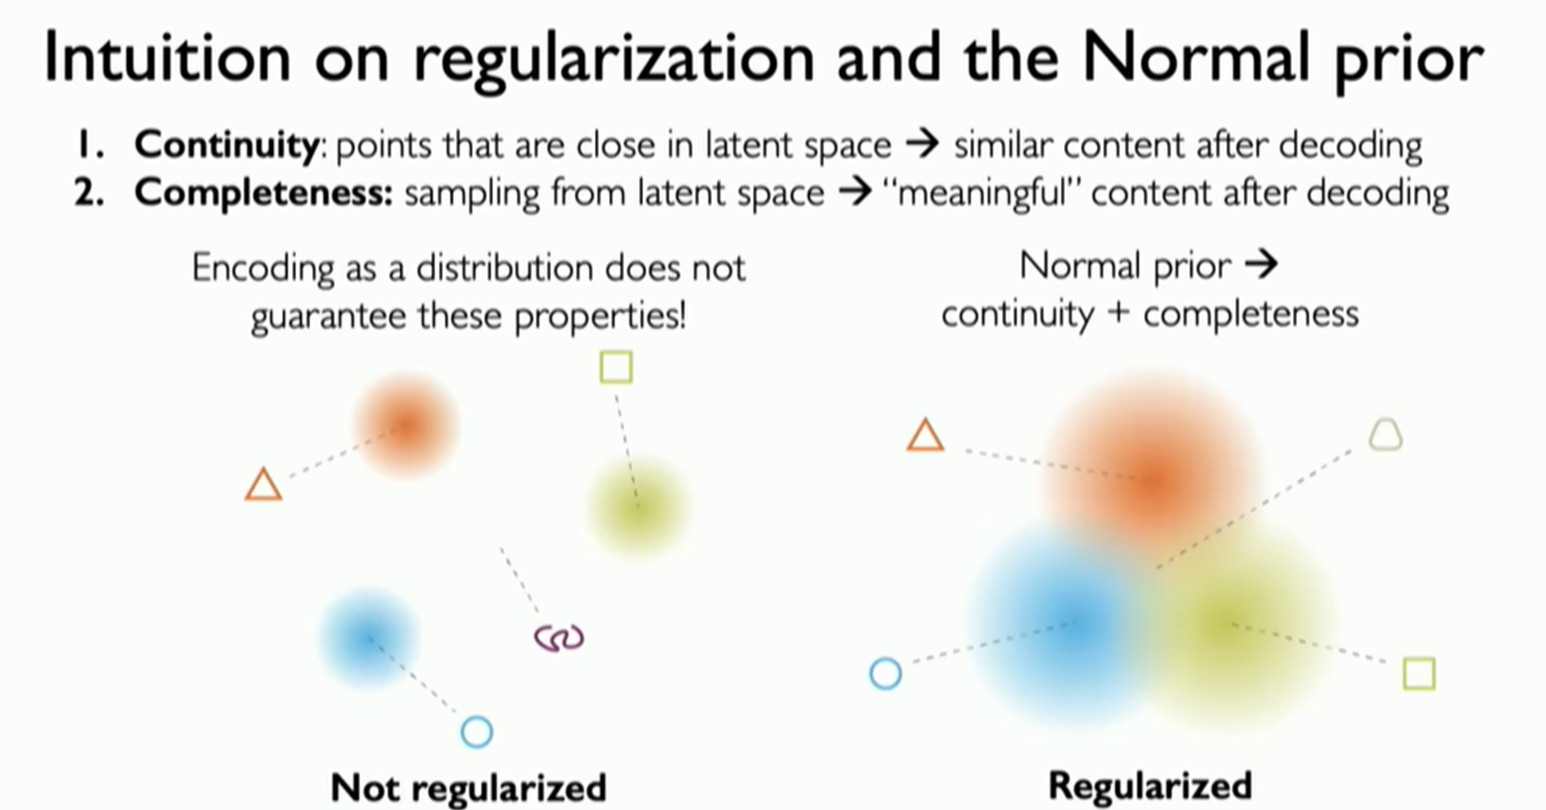

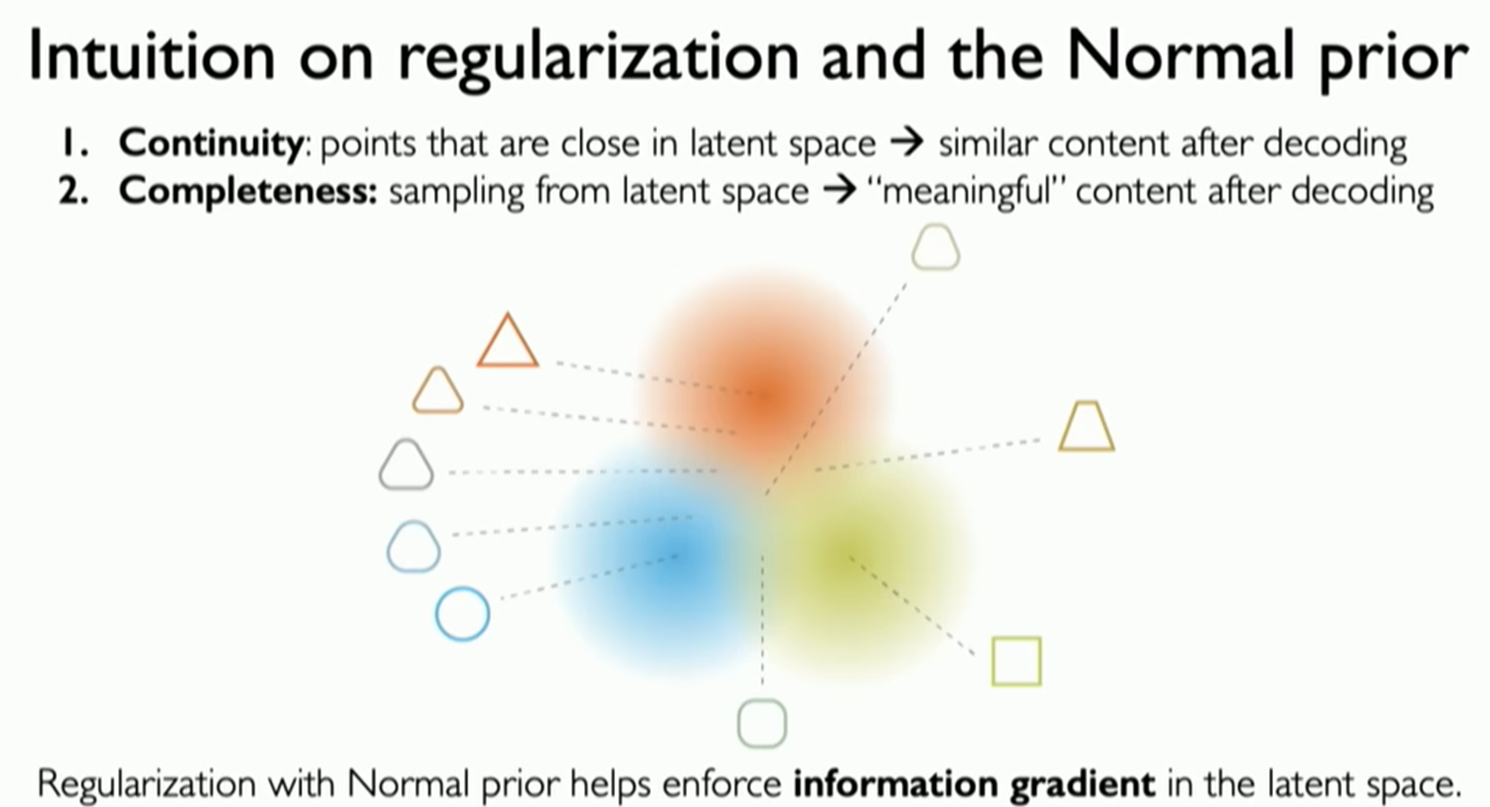

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

Create a custom layer (always define the call function) for smapling epsilon (for the **reparametrization trick**)

It takes as input the parameters of the distribution (mean and variance) and output a differentiable function  

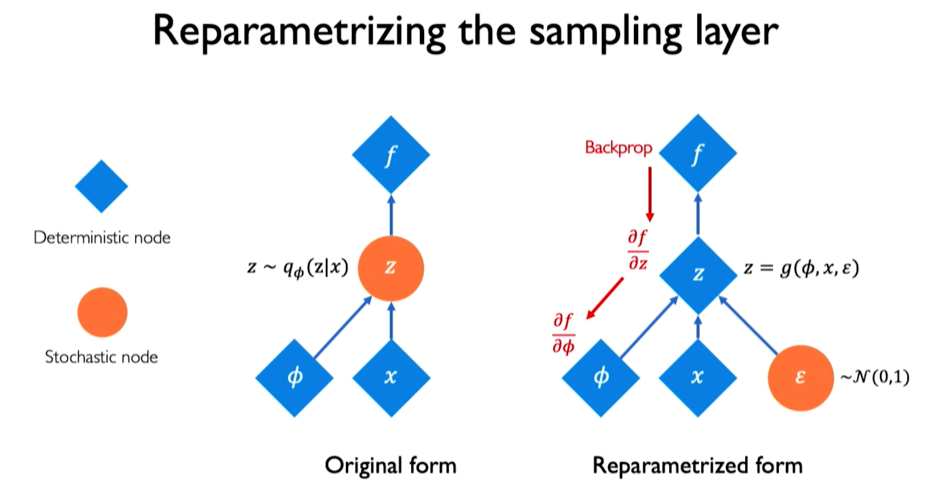

In [12]:
from tensorflow import keras 
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [8]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
(x_train, _), (x_test, _) = fashion_mnist.load_data()
mnist_fashion = np.concatenate([x_train, x_test], axis=0)
mnist_fashion = np.expand_dims(mnist_fashion, -1).astype("float32") / 255

mnist_fashion.shape

(70000, 28, 28, 1)

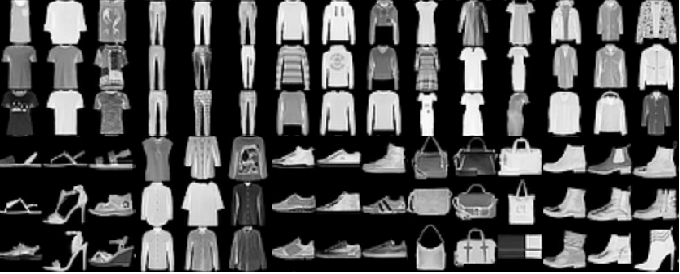

## Build the encoder

In [14]:
latent_dim = 50
#50 medie e 50 deviazioni standard

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Build the decoder

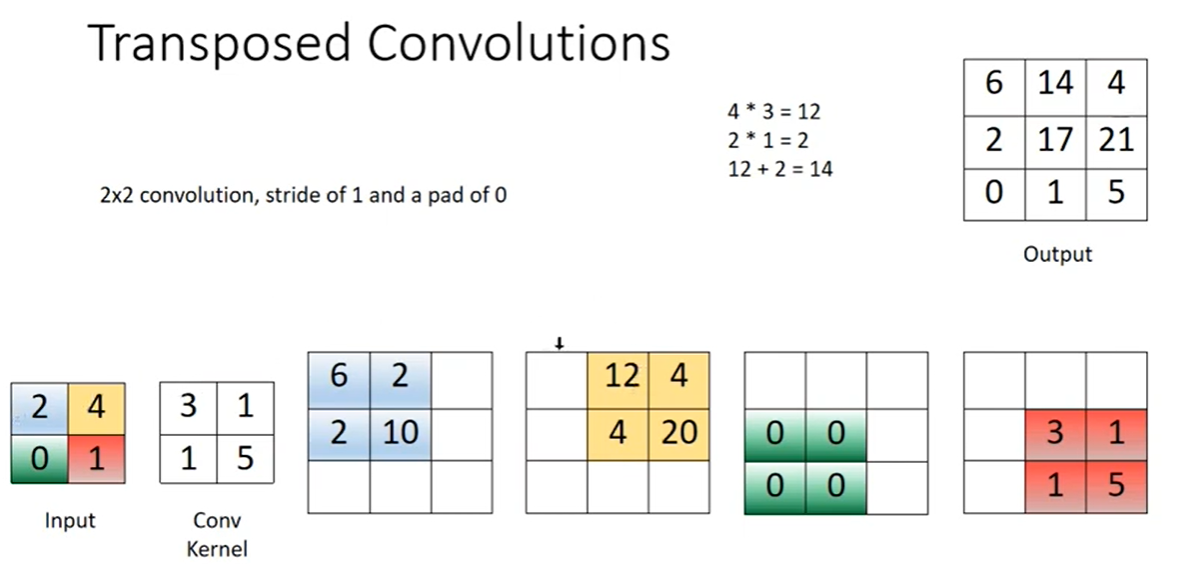

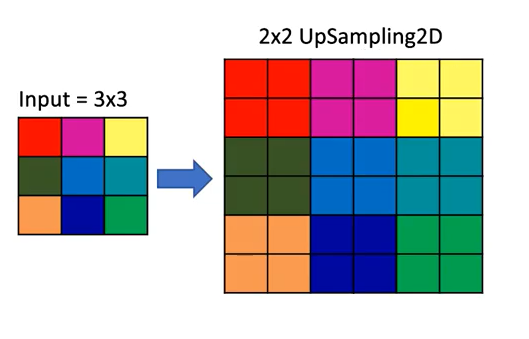

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              159936    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a `Model` with a custom `train_step`

Here we try to enforce the latent distribution to be a **normal distribution** by adding a term to the loss.

This term comes from the **Kullback–Leibler divergence**: *a metric to measure the difference between 2 probability distributions*

>Why we want normally distributed latent distribution:


*   Encurages encodings to be distributed evenly around a center of the latent space
*   Enhance continuity of the into latent space



In [16]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_fashion, epochs=30, batch_size=250)

Epoch 1/30
280/280 [==============================] - 18s 11ms/step - loss: 379.2855 - reconstruction_loss: 308.7970 - kl_loss: 13.2968
Epoch 2/30
280/280 [==============================] - 3s 11ms/step - loss: 266.2390 - reconstruction_loss: 246.9100 - kl_loss: 15.8973
Epoch 3/30
280/280 [==============================] - 3s 11ms/step - loss: 255.8385 - reconstruction_loss: 238.5818 - kl_loss: 15.1858
Epoch 4/30
280/280 [==============================] - 3s 11ms/step - loss: 250.0426 - reconstruction_loss: 234.0269 - kl_loss: 14.9017
Epoch 5/30
280/280 [==============================] - 3s 11ms/step - loss: 246.9222 - reconstruction_loss: 231.3793 - kl_loss: 14.9113
Epoch 6/30
280/280 [==============================] - 3s 11ms/step - loss: 244.3122 - reconstruction_loss: 229.5895 - kl_loss: 15.0693
Epoch 7/30
280/280 [==============================] - 3s 11ms/step - loss: 243.1132 - reconstruction_loss: 228.3214 - kl_loss: 15.2101
Epoch 8/30
280/280 [==============================] - 

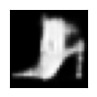

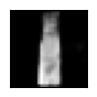

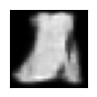

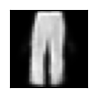

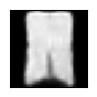

In [28]:
import matplotlib.pyplot as plt

for i in range (5):
  plt.figure(figsize=(1,1))
  sample = tf.random.normal(shape=(3,latent_dim))

  x_decoded = vae.decoder.predict(sample, verbose=0)

  img = np.reshape(x_decoded[0], (28,28))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='gray')
  plt.show()

### **References**
>© Alexander Amini and Ava Amini \\
MIT 6.S191: Introduction to Deep Learning \\
IntroToDeepLearning.com


>https://keras.io/examples/generative/vae/